<a href="https://colab.research.google.com/github/rohandawar/pyspark/blob/main/GLM_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I am trying to implement Logistic Regression on ** CanCer Dataset**

In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=f4fc606d322cb6a4f70bc310715c4cb3d52b88c551dfe4dcd8f69f9345edcac0
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [20]:
# import Libs

# Pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Google Colab
from google.colab import drive

# Plotting
import matplotlib.pyplot as plt


In [4]:
# Start the spark session
spark = SparkSession.builder.appName('LogicticRegression').getOrCreate()

In [5]:
# Mount the drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [10]:
!ls /content/drive/MyDrive/DataSets_Pyspark_GoogleColab_Primer

 Boston.csv	   ' Countries_LandCvr_Elnino.csv'
 cancer_tumor.csv   glassClass.csv


In [11]:
# read the data
path = '/content/drive/MyDrive/DataSets_Pyspark_GoogleColab_Primer/cancer_tumor.csv'
df1 = spark.read.csv(path, inferSchema=True, header=True)
df1.show()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [12]:
#Conversion for Diagnosis columns
df2 = df1.withColumn('diagnosis', F.when(F.col('diagnosis')=='M',1).otherwise(0))
df2.show()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|
+---------+-----------+------------+--------------+---------+-----

In [13]:
# Checking the class distribution
df2.groupBy('diagnosis').count().show()

+---------+-----+
|diagnosis|count|
+---------+-----+
|        1|  212|
|        0|  357|
+---------+-----+



In [18]:
pred_columns = [field for (field, dataType) in df2.dtypes if field!='diagnosis']

# Instiate VectorAssembler
vec_assembler = VectorAssembler(inputCols=pred_columns, outputCol='features')

# Transform the data
Outputdf = vec_assembler.transform(df2)
Outputdf.show()

+---------+-----------+------------+--------------+---------+---------------+----------------+--------------+-------------------+-------------+----------------------+---------+----------+------------+-------+-------------+--------------+------------+-----------------+-----------+--------------------+------------+-------------+---------------+----------+----------------+-----------------+---------------+--------------------+--------------+-----------------------+--------------------+
|diagnosis|radius_mean|texture_mean|perimeter_mean|area_mean|smoothness_mean|compactness_mean|concavity_mean|concave points_mean|symmetry_mean|fractal_dimension_mean|radius_se|texture_se|perimeter_se|area_se|smoothness_se|compactness_se|concavity_se|concave points_se|symmetry_se|fractal_dimension_se|radius_worst|texture_worst|perimeter_worst|area_worst|smoothness_worst|compactness_worst|concavity_worst|concave points_worst|symmetry_worst|fractal_dimension_worst|            features|
+---------+-----------+-

In [28]:
# Train, Test Split
train_df, test_df = Outputdf.randomSplit([0.7, 0.3], seed=42)

# Instiate Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='diagnosis', maxIter=10)

# Train the model
lr_model = lr.fit(train_df)

In [29]:
# plot the area Under curve for Test data
lr_model_summary = lr_model.summary
roc = lr_model_summary.roc.toPandas()

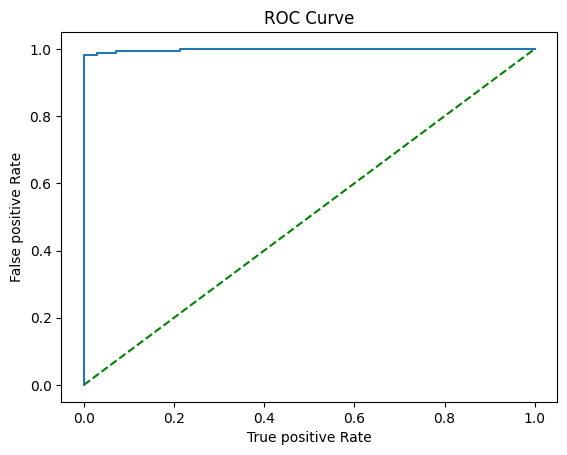

TrainSet areaUnderRoc: 0.9980263157894739


In [30]:
# Plotting
plt.plot([0,1], [0,1], 'g--')
plt.plot(roc['FPR'], roc['TPR'])
plt.ylabel('False positive Rate')
plt.xlabel('True positive Rate')
plt.title('ROC Curve')
plt.show()
print('TrainSet areaUnderRoc:', str(lr_model_summary.areaUnderROC))

In [32]:
# Model Performance on test Data
lr_model_test = lr_model.transform(test_df)
evaulator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='diagnosis')
print('Test AUC:', evaulator.evaluate(lr_model_test))

Test AUC: 0.9968300929839391
